# **SET-UP**

In this section, the relavant libraries are imported, and the training, validation and test datasets are prepared.

If the notebook is running on Google Colab, the data can be downloaded to the environment by running the corresponding cell.

In [1]:
# imports

import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

### Download Data into Google Colab Environment

This cell should only be executed if the notebook is running on Google Colab.

If the notebook is running locally with the data already situated in the correct directory, this cell block should **not** be run.

In [2]:
# download if zip files not already downloaded
if not os.path.exists('data.zip'):
    !gdown '1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW'
else:
    print('data.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('data'):
    !unzip -qq data.zip
    !rm data.zip
else:
    print('data folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW
From (redirected): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW&confirm=t&uuid=9d02359d-42b2-4d52-83e8-c5378222802c
To: /content/data.zip
100% 289M/289M [00:04<00:00, 65.2MB/s]


In [3]:
# download if zip files not already downloaded
if not os.path.exists('utils.zip'):
    !gdown '1gpmibySGF2wxCMRcE_0V9duUf27U5270'
else:
    print('utils.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('utils'):
    !unzip -qq utils.zip
    !rm utils.zip
else:
    print('utils folder already exists')

Downloading...
From: https://drive.google.com/uc?id=1gpmibySGF2wxCMRcE_0V9duUf27U5270
To: /content/utils.zip
100% 2.85k/2.85k [00:00<00:00, 13.5MB/s]


In [4]:
# download if zip files not already downloaded
if not os.path.exists('depth_estimation.zip'):
    !gdown '1aNww-oYs-eObTImT923rFejQDDLsfOI6'
else:
    print('depth_estimation.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('depth_estimation'):
    !unzip -qq depth_estimation.zip
    !rm depth_estimation.zip
else:
    print('depth_estimation folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1aNww-oYs-eObTImT923rFejQDDLsfOI6
From (redirected): https://drive.google.com/uc?id=1aNww-oYs-eObTImT923rFejQDDLsfOI6&confirm=t&uuid=49c2dceb-b45a-4046-962c-5b1845572c06
To: /content/depth_estimation.zip
100% 55.4M/55.4M [00:00<00:00, 61.5MB/s]


In [5]:
# download if zip files not already downloaded
if not os.path.exists('object_segmentation.zip'):
    !gdown '1MyVDhgv_Ni2WQhRUvVupyejGuZE3Sdkw'
else:
    print('object_segmentation.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('object_segmentation'):
    !unzip -qq object_segmentation.zip
    !rm object_segmentation.zip
else:
    print('object_segmentation folder already exists')

Downloading...
From: https://drive.google.com/uc?id=1MyVDhgv_Ni2WQhRUvVupyejGuZE3Sdkw
To: /content/object_segmentation.zip
100% 2.61k/2.61k [00:00<00:00, 9.44MB/s]


## Constructing Datasets

Informally experimenting with various batch sizes,demonstrated that a batch size of four yielded the best results.

In [6]:
# batch size
B = 4

The appropriate transformations can be applied for training, validation and test data. The dataset is split into 60% for training data, 10% for validation data, and 30% for test data.

In [7]:
from torch.utils.data import random_split, DataLoader
from utils.seq_dataset import SeqDataset
from utils.data_management import get_transform, initialize_loader

# set up dataset
dataset = SeqDataset(root_dir='data', transform=None)

# picking out the sizes
train_size = int(0.6 * len(dataset))              # 60% for training
val_size = int(0.1 * len(dataset))                # 10% for validation
test_size = len(dataset) - train_size - val_size  # 30 for testing

# split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# dataloaders
train_loader = initialize_loader(train_dataset, get_transform("train"), B, True)
val_loader = initialize_loader(val_dataset, get_transform("validation"), B, False)
test_loader = initialize_loader(test_dataset, get_transform("test"), B, False)

### Visualize Data

This cell can be optionally executed to visualize the structure of the dataset.

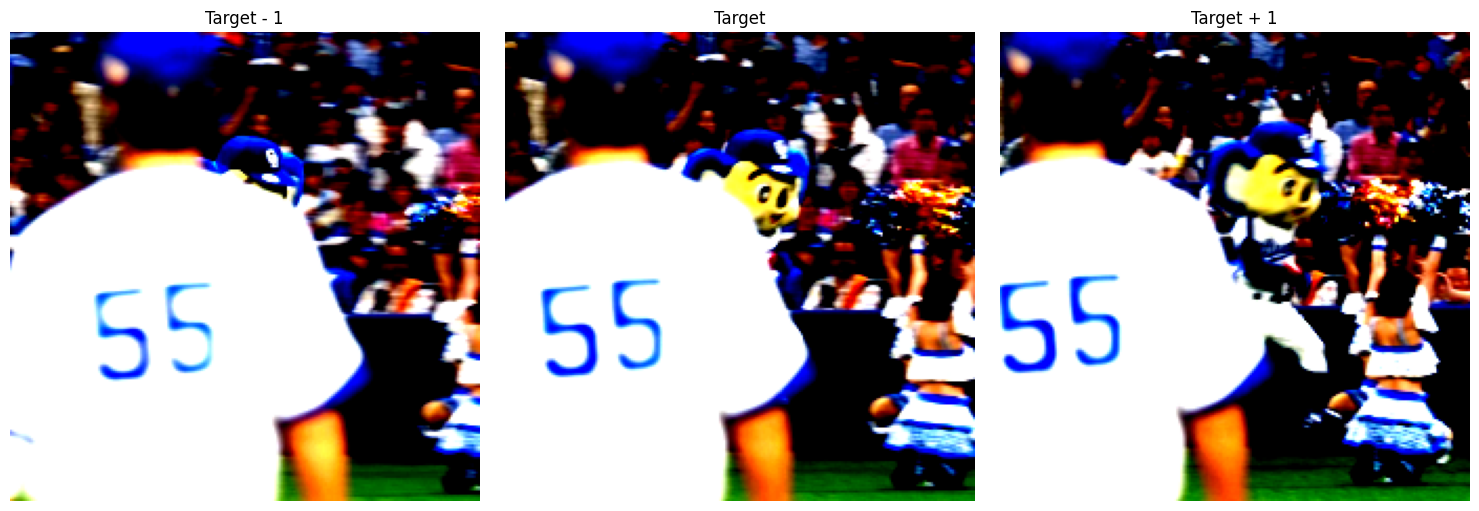

In [8]:
tgt, [s1, s2] = train_dataset[10]
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Target - 1")
plt.imshow(s1.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(tgt.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target + 1")
plt.imshow(s2.permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

# **ARCHITECTURE**

#### Helper Functions

In [35]:
def extract_features(extractor, image):
    with torch.no_grad():
        image = F.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)
        image = image * 2 - 1
        output = extractor.forward_features(image)
        patch_tokens = output["x_norm_patchtokens"]
        B, N, C = patch_tokens.shape
        H = W = int(N ** 0.5)
        features = patch_tokens.permute(0, 2, 1).reshape(B, C, H, W)
    return features

def get_masks(obj_net, features):
    with torch.no_grad():
      masks = obj_net(features)
    return masks

def get_depth(depth_net, image):
    with torch.no_grad():
        disp = depth_net(tgt)
        disp = F.interpolate(disp, size=(224, 224), mode='bilinear', align_corners=True)
        depth = 1 / (disp + 1e-6)
    return depth

def get_centroid(mask):
    if mask.dim() == 3:
        mask = mask[0]
    y, x = torch.nonzero(mask, as_tuple=True)
    if len(x) == 0:
        return torch.tensor([0.0, 0.0], device=mask.device)
    centroid = torch.stack([x.float().mean(), y.float().mean()])
    return centroid

#### Loss Functions

In [108]:
import torch
import torch.nn.functional as F

def contrastive_loss(nodes):
    nodes_batch = torch.stack(nodes, dim=0)

    B, N, D = nodes_batch.shape

    anchors = nodes_batch[:, 0::2, :]
    positives = nodes_batch[:, 1::2, :]

    anchors = F.normalize(anchors, dim=-1)
    positives = F.normalize(positives, dim=-1)
    all_nodes = F.normalize(nodes_batch, dim=-1)

    pos_sim = torch.sum(anchors * positives, dim=-1)

    idxs = torch.arange(N, device=nodes_batch.device)
    idxs = idxs.view(1, N, 1)

    anchor_idxs = torch.arange(0, N, 2, device=nodes_batch.device)
    pos_idxs = anchor_idxs + 1

    anchor_idxs = anchor_idxs.view(1, 1, -1)
    pos_idxs = pos_idxs.view(1, 1, -1)
    mask = (idxs != anchor_idxs) & (idxs != pos_idxs)

    all_nodes_T = all_nodes.transpose(1, 2)
    sim_all = torch.bmm(anchors, all_nodes_T)

    sim_neg = sim_all.masked_fill(~mask.transpose(1, 2), float('-inf'))

    neg_sim = torch.logsumexp(sim_neg, dim=-1)

    loss = -pos_sim + neg_sim

    return loss.mean()


In [122]:
def mse_debug_loss(nodes_batch):
    total_loss = 0.0
    for nodes in nodes_batch:
        target = torch.zeros_like(nodes)
        total_loss += F.mse_loss(nodes, target)
    return total_loss / len(nodes_batch)


In [126]:
def mse_loss(nodes_batch):
    nodes = torch.stack(nodes_batch, dim=0)
    target = torch.zeros_like(nodes)
    loss = F.mse_loss(nodes, target)
    return loss

In [ ]:
import torch
import torch.nn.functional as F

def triplet_loss(nodes_batch, margin=1.0):
    total_loss = 0.0
    total_triplets = 0

    for nodes in nodes_batch:
        num_nodes = nodes.shape[0]
        nodes = F.normalize(nodes, dim=1)

        for i in range(0, num_nodes - 1, 2):
            anchor = nodes[i]
            positive = nodes[i+1]

            negatives = torch.stack([nodes[j] for j in range(num_nodes) if j != i and j != i+1])

            pos_dist = F.pairwise_distance(anchor.unsqueeze(0), positive.unsqueeze(0), p=2)
            neg_dists = F.pairwise_distance(anchor.unsqueeze(0), negatives, p=2)

            hardest_neg_dist = neg_dists.min()

            loss_i = F.relu(pos_dist - hardest_neg_dist + margin)
            total_loss += loss_i
            total_triplets += 1

    return total_loss / total_triplets if total_triplets > 0 else torch.tensor(0.0, device=nodes_batch[0].device)

#### Scene Constructor

In [109]:
class SceneGraphConstructor(nn.Module):
    def __init__(self, feat_dim, node_dim, edge_dim):
        super().__init__()
        self.node_mlp = nn.Sequential(
            nn.Linear(feat_dim + 1, 128), nn.ReLU(),
            nn.Linear(128, node_dim)
        )
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + 3, 128), nn.ReLU(),
            nn.Linear(128, edge_dim)
        )

    def forward(self, masks, depth, feats):
        B, N_obj, H, W = masks.shape
        _, C, Hf, Wf = feats.shape
        device = feats.device

        all_nodes = []
        all_edge_index = []
        all_edge_attr = []

        for b in range(B):
            m = masks[b]
            d = depth[b, 0]
            f = feats[b]


            if (H, W) != (Hf, Wf):
                m = F.interpolate(m.unsqueeze(0), size=(Hf, Wf), mode='bilinear', align_corners=False).squeeze(0)
            if d.shape != (Hf, Wf):
                d_resized = F.interpolate(d.unsqueeze(0).unsqueeze(0), size=(Hf, Wf), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
            else:
                d_resized = d

            node_feats = []
            for i in range(N_obj):
                mask_i = m[i]
                pooled_feat = (mask_i * f).view(C, -1).sum(dim=1) / (mask_i.sum() + 1e-6)
                avg_depth = (mask_i * d_resized).sum() / (mask_i.sum() + 1e-6)
                node_input = torch.cat([pooled_feat, avg_depth.unsqueeze(0)])
                v_i = self.node_mlp(node_input)
                node_feats.append(v_i)

            node_feats = torch.stack(node_feats)
            all_nodes.append(node_feats)

            edge_idx = []
            edge_feats = []

            for i in range(N_obj):
                for j in range(N_obj):
                    if i == j: continue

                    delta_pos = get_centroid(m[j]) - get_centroid(m[i])
                    delta_depth = node_feats[j][-1] - node_feats[i][-1]

                    edge_input = torch.cat([node_feats[i], node_feats[j], delta_pos, delta_depth.unsqueeze(0)])
                    e_ij = self.edge_mlp(edge_input)

                    edge_idx.append([i, j])
                    edge_feats.append(e_ij)

            edge_index = torch.tensor(edge_idx, device=device).T
            edge_attr = torch.stack(edge_feats)

            all_edge_index.append(edge_index)
            all_edge_attr.append(edge_attr)

        return all_nodes, all_edge_index, all_edge_attr

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.trainer import Trainer

class ConstructionTrainer(Trainer):
    def __init__(self, constructor, optimizer, train_loader, device, obj_net, depth_net, dino, epochs=100):

        # initialize parameters in general trainer class
        super().__init__(
            model=constructor,
            optimizer=optimizer,
            train_loader=train_loader,
            device=device,
            epochs=epochs)

        self.dino = dino
        self.depth_net = depth_net
        self.obj_net = obj_net

        self.model.to(device)
        self.dino.eval()
        self.depth_net.eval()
        self.obj_net.eval()

    def fwd_pass(self, input_data):

        # unpack input data
        tgt, _ = input_data
        tgt = tgt.to(self.device)

        # components of feature vector
        features = extract_features(self.dino, tgt)
        masks = get_masks(self.obj_net, features)
        depth_map = get_depth(self.depth_net, tgt)

        # values of the graph
        nodes, edge_index, edge_attr = self.model(masks, depth_map, features)

        # compute loss
        #loss = contrastive_loss(nodes)
        loss = mse_loss(nodes)

        return loss

# **TRAINING**

In [38]:
from utils.visual_helpers import plot_train_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Pretrained Models

In [117]:
# load pretrained dino for backbone feature detector
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
feat_dim = 768  # fixed value

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [118]:
from depth_estimation.depth_net import DepthNet
from depth_estimation.pose_net import PoseNet

depth_net = DepthNet().to(device)
pose_net = PoseNet().to(device)

depth_net.load_state_dict(torch.load("depth_estimation/weights/depth_D_weights.pth", map_location=torch.device('cpu')))
pose_net.load_state_dict(torch.load("depth_estimation/weights/pose_D_weights.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [119]:
from object_segmentation.object_detector import ObjSegmentation

obj_net = ObjSegmentation(feat_dim).to(device)

obj_net.load_state_dict(torch.load("object_segmentation/weights/solo_obj_detector_a.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

## Version A: Construction Loss

In [120]:
node_dim = 64
edge_dim = 64
sg_constructor = SceneGraphConstructor(feat_dim, node_dim, edge_dim).to(device)
optimizer = torch.optim.Adam(sg_constructor.parameters(), lr=1e-3)
sg_trainer = ConstructionTrainer(sg_constructor, optimizer, train_loader, device, obj_net, depth_net, dino, epochs=5)

In [121]:
sg_trainer.train()


EPOCH 1 -----------------------------
[average loss: 2.0794]

EPOCH 2 -----------------------------
[average loss: 2.0794]

EPOCH 3 -----------------------------
[average loss: 2.0794]

EPOCH 4 -----------------------------


KeyboardInterrupt: 

## Version B: MSE Loss

In [128]:
node_dim = 64
edge_dim = 64
sg_constructor_b = SceneGraphConstructor(feat_dim, node_dim, edge_dim).to(device)
optimizer = torch.optim.Adam(sg_constructor_b.parameters(), lr=1e-3)
sg_trainer_b = ConstructionTrainer(sg_constructor_b, optimizer, train_loader, device, obj_net, depth_net, dino, epochs=5)

In [129]:
sg_trainer_b.train()


EPOCH 1 -----------------------------
[average loss: 0.0011]

EPOCH 2 -----------------------------
[average loss: 0.0000]

EPOCH 3 -----------------------------
[average loss: 0.0000]

EPOCH 4 -----------------------------


KeyboardInterrupt: 

## Version C: Triplet Loss

In [ ]:
node_dim = 64
edge_dim = 64
sg_constructor = SceneGraphConstructor(feat_dim, node_dim, edge_dim).to(device)
optimizer = torch.optim.Adam(sg_constructor.parameters(), lr=1e-3)
sg_trainer = ConstructionTrainer(sg_constructor, optimizer, train_loader, device, obj_net, depth_net, dino, epochs=5)

In [ ]:
sg_trainer.train()


EPOCH 1 -----------------------------
[average loss: 2.0794]

EPOCH 2 -----------------------------
[average loss: 2.0794]

EPOCH 3 -----------------------------


In [ ]:
sg_trainer.train()


EPOCH 1 -----------------------------
[average loss: 2.0794]

EPOCH 2 -----------------------------
[average loss: 2.0794]

EPOCH 3 -----------------------------


# **EVALUATION**

##### Helper Functions

In [170]:
import torch
import matplotlib.pyplot as plt
import networkx as nx

def draw_scene_graph(node_feats, edge_index, title=None):

    G = nx.Graph()
    num_nodes = node_feats.shape[0]

    for i in range(num_nodes):
        G.add_node(i)

    edge_index = edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        G.add_edge(src, dst)

    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=600, font_size=10)
    if title:
        plt.title(title)
    plt.show()


def val_results(constructor, depth_net=depth_net, obj_net=obj_net):
    depth_net.eval()
    obj_net.eval()
    constructor.eval()
    dino.eval()

    with torch.no_grad():
        count = 0
        for input in val_loader:
            tgt, _ = input
            tgt = tgt.to(device)

            features = extract_features(dino, tgt)

            depth = get_depth(depth_net, tgt)


            masks = get_masks(obj_net, features)


            nodes, edges, _ = constructor(masks, depth, features)

            for i in range(4):
                node_feats = nodes[i]
                edge_index = edges[i]

                print(f"Image {i+1}")
                print(f"  node_feats shape: {node_feats.shape}")
                print(f"  edge_index shape: {edge_index.shape}")

                draw_scene_graph(node_feats, edge_index, title=f"Scene Graph - Image {count+1}")

            break

#### Sample Image

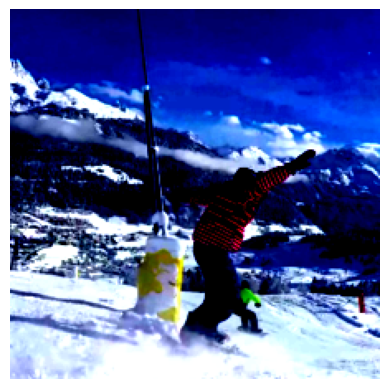

In [ ]:
plt.imshow(image_np)
plt.axis('off')
plt.show()

## Version A: Constrastive

Image 1
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


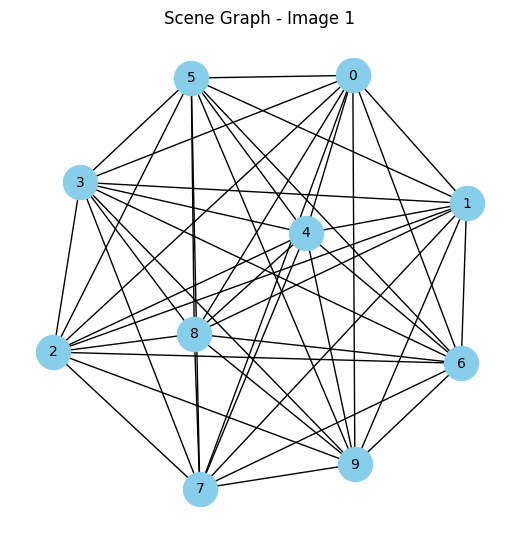

Image 2
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


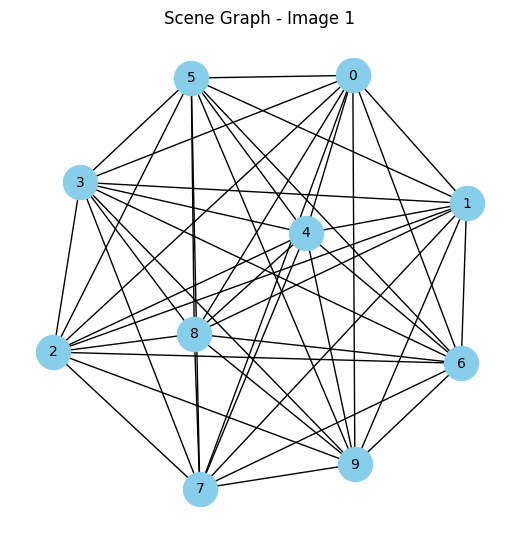

Image 3
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


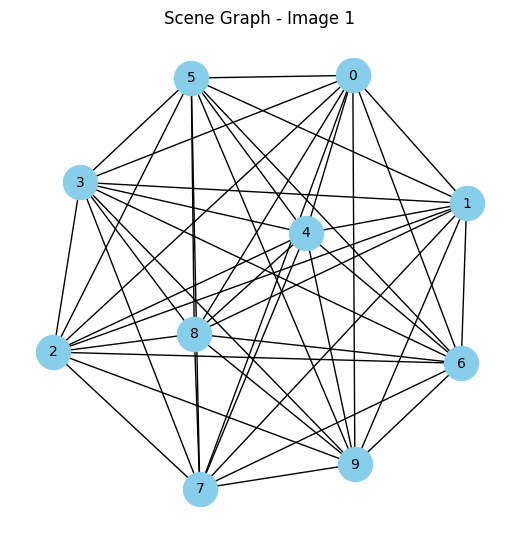

Image 4
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


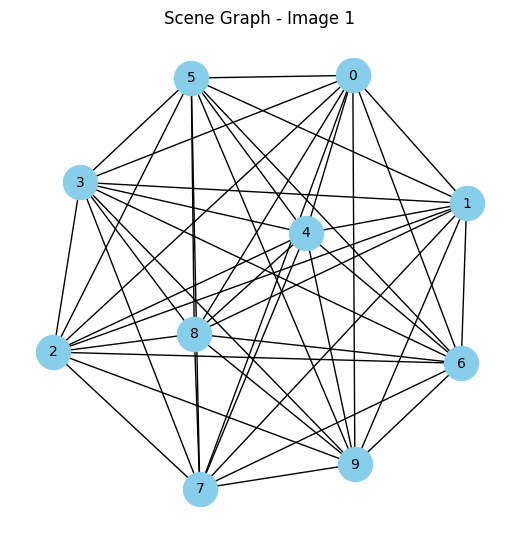

In [171]:
val_results(sg_constructor)

## Version B: MSE

Image 1
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


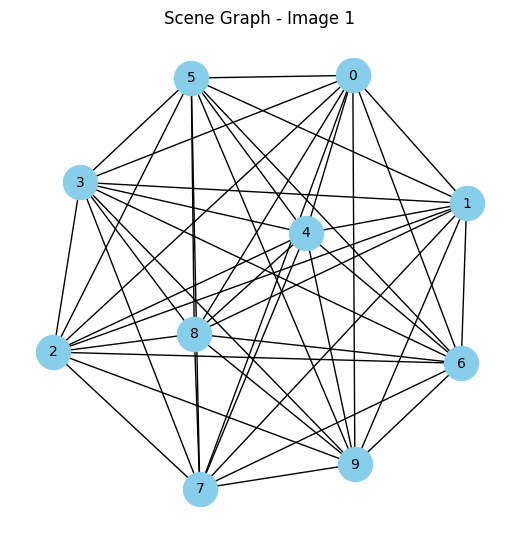

Image 2
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


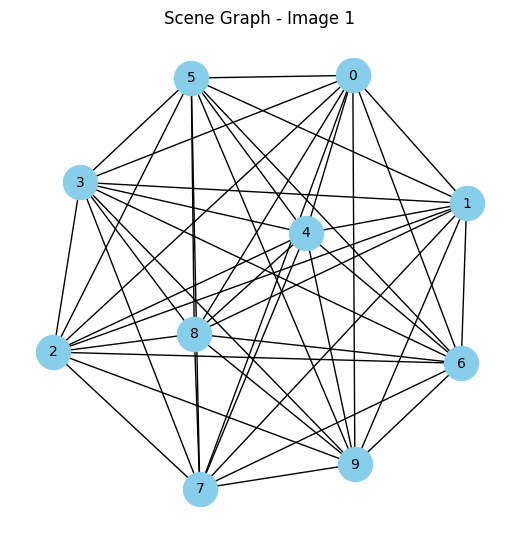

Image 3
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


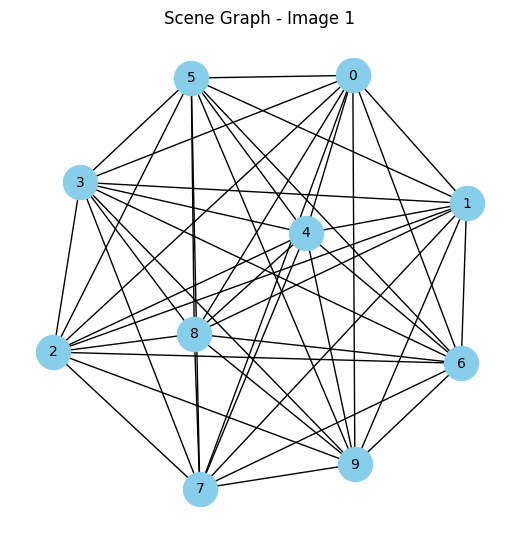

Image 4
  node_feats shape: torch.Size([10, 64])
  edge_index shape: torch.Size([2, 90])


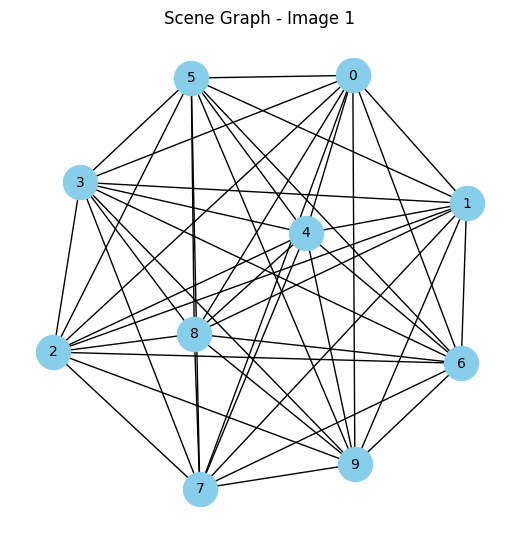

In [172]:
val_results(sg_constructor_b)

## Version C: Triple

In [ ]:
val_results(sg_constructor_c)